## Agitation Video Analysis 

This notebook may be used as a tool to determine the approximate mixing times of agitated glass vessels.

In [1]:
import imageio as iio; import cv2; import numpy as np; import matplotlib.pyplot as plt; from tqdm import tqdm; import os; import tkinter as tk;
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from ipywidgets import interactive
import pandas as pd
import sys
import cv2

1. Upload video to the files (on the left)
2. Change the variable ```video_name``` to the file name of the uploaded video

In [2]:
video_name = '20231017160909_MVI_0552.mp4'
cap = cv2.VideoCapture(video_name)
success,image = cap.read()
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
fps = int(cap.get(cv2.CAP_PROP_FPS))

Change the values here to crop the image appropriately

Note: You may need to move these sliders **slowly**. Do not run the cell again after changing the values, as it will reset the sliders.

In [3]:
x = len(image[0,:])
y = len(image[:,0])

horizontal_slider = widgets.FloatRangeSlider(
    value=[0,x], 
    min=0., max=x, step=1.,
    description='Horizontal:',
    readout_format='.1f',
)

vertical_slider = widgets.FloatRangeSlider(
    value=[0,y], 
    min=0., max=y, step=1.,
    description='Vertical:',
    readout_format='.1f',
)

def crop(x,y):
    left,right = x 
    top,bottom = y
    left = int(left)
    top = int(top)
    bottom = int(bottom)
    right = int(right)
    print(left,right,top,bottom)
    img = image[top:bottom,left:right]
    plt.imshow(img)
    plt.xticks([],[])
    plt.yticks([],[])
    plt.show()

interactive_plot = interactive(
    crop, 
    x=horizontal_slider,
    y=vertical_slider
)
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(FloatRangeSlider(value=(0.0, 1920.0), description='Horizontal:', max=1920.0, readout_for…

In [4]:
left,right = horizontal_slider.value
top,bottom = vertical_slider.value
left,right,top,bottom = int(left),int(right),int(top),int(bottom)
frames = np.empty((num_frames, bottom-top, right-left), dtype=np.uint8)
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
for i in tqdm(range(num_frames)):
    ret, frame = cap.read()
    if ret:
        frames[i] = np.mean(frame[top:bottom,left:right,:],axis=2)
cap.release()

100%|██████████| 583/583 [00:07<00:00, 76.69it/s]


Now extract the relevant quantities from the respective frames

In [10]:
mean = np.mean(frames,axis=(1,2)); std = np.std(frames,axis=(1,2))
quantiles = [0,10,20,30,40,50,60,70,80,90,100]
result = []

for frame in tqdm(frames):
    frame_quantiles = [np.percentile(frame, q) for q in quantiles]
    result.append(frame_quantiles)
result = np.array(result)

100%|██████████| 583/583 [00:14<00:00, 40.35it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


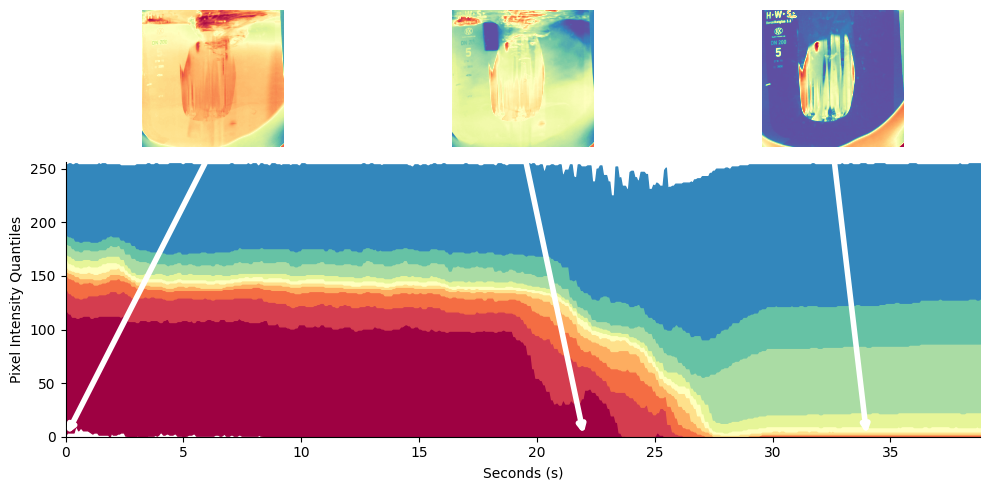

In [55]:
try:
    os.mkdir('results')
except:
    pass

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 5))
gs = GridSpec(2, 3, height_ratios=[1, 2])
ax =  fig.add_subplot(gs[1, :])

seconds = np.arange(len(mean))/fps
ax.legend(frameon=False)
ax.set_xlim(0,seconds[-1])
ax.set_xlabel('Seconds (s)')

# evenly spaced b_w cols 
import matplotlib.colors as mcolors
def generate_hex_colors(colormap_name, n):
    cmap = plt.get_cmap(colormap_name)
    colors = [mcolors.rgb2hex(cmap(i/n)) for i in range(n)]
    return colors

n = len(quantiles)-1
# black and white
colormap_name = "Spectral"
cols = generate_hex_colors(colormap_name, n)

for i in range(len(quantiles)-1):
    ax.fill_between(seconds,result[:,i],result[:,i+1],color = cols[i],lw=1,alpha=1)

ax.set_ylabel('Pixel Intensity Quantiles')

ax.legend(frameon=False)
ax.set_ylim(0,256)
# turn off right and top axis
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.tight_layout()


# Create subplots for images in the upper part of the grid
axins1 = fig.add_subplot(gs[0, 0])
axins2 = fig.add_subplot(gs[0, 1])
axins3 = fig.add_subplot(gs[0, 2])
axs = [axins1,axins2,axins3]


s = [0,22,34]
f = [s_i * fps for s_i in s]
images = [frames[f_i] for f_i in f]

for i in range(len(s)):
    axs[i].imshow(images[i], cmap=colormap_name)
    axs[i].axis('off')
    ax.annotate("",
                xy=(s[i], 0), xycoords="data",
                xytext=(images[i].shape[1] / 2, images[i].shape[0]), textcoords=axs[i].transData,
                arrowprops=dict(arrowstyle="->",
                                linewidth=4,
                                color='white',
                                connectionstyle="arc3")
            )

plt.savefig('results/plot_'+str(video_name.split('.')[0])+'.png',dpi=600)

plt.show()

In [26]:
res_df = {'Time (s)':seconds,'Frame Intensity (Mean)':mean,'Frame Intensity (Standard Deviation)':std}
for i in range(len(quantiles)):
    res_df[str(quantiles[i])+'% Quantile'] = result[:,i]

df_res = pd.DataFrame(res_df)
df_res.to_csv('results/data_'+str(video_name.split('.')[0])+'.csv',index=False)